<a href="https://colab.research.google.com/github/SantosCristiano/artificial-intelligence-python/blob/main/06_neural_network_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 20 - Tensor Flow - Redes Neurais - MNIST

# TensorFlow 2.0
Este notebook é baseado no Tensorflow no notebook de **Martin Gorner** e foi modificado para ser executado no TensorFlow 2.0.

## 1. Introdução
Nesta prática, você aprenderá como construir e treinar uma rede neural que reconhece dígitos manuscritos. <br />Ao longo do caminho, conforme você aprimora sua rede neural para atingir 99% de precisão, você também descobrirá as ferramentas comerciais que os profissionais de aprendizado profundo usam para treinar seus modelos com eficiência.

Este codelab usa o conjunto de dados MNIST, uma coleção de 60.000 dígitos rotulados que manteve gerações de PhDs ocupadas por quase duas décadas.<br /> Você resolverá o problema com menos de 100 linhas de código Python / TensorFlow.

O que você aprenderá:
* O que é uma rede neural e como treiná-la
* Como construir uma rede neural básica de 1 camada usando TensorFlow
* Como adicionar mais camadas
* Dicas e truques de treinamento: overfitting, evasão, diminuição da taxa de aprendizagem ...
* Como solucionar problemas de redes neurais profundas
* Como construir redes convolucionais

O que você precisará:
* Python 2 ou 3 (Python 3 recomendado)
* TensorFlow

### Executando na GPU
Para esta prática, você precisará usar uma GPU para acelerar o treinamento.<br /> Para fazer isso, vá ao menu "Runtime" do Colab, selecione "Alterar tipo de tempo de execução" e, no menu pop-up, escolha "GPU" na caixa "Acelelador de hardware". Isso é tudo que você precisa fazer, Colab e Tensorflow cuidarão do resto!

### Requisitos de instalação
Primeiro, precisamos instalar o TensorFlow 2.0 e fazer o download do ngrock (o ngrock só é usado para executar o TensorBoard no Google Colab).

In [ ]:
import os
import datetime
import numpy as np

import tensorflow as tf

In [ ]:
#@title Dependências e importações (EXECUTE-ME!) { display-mode: "form" }

! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

from __future__ import absolute_import, division, print_function



--2021-09-01 03:01:49--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 18.205.222.128, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  12.7MB/s    in 1.0s    

2021-09-01 03:01:51 (12.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


### TensorBoard
TensorBoard é uma ferramenta usada para monitorar o treinamento e investigar o modelo e os resultados.

Execute a próxima célula para iniciar o TensorBoard em segundo plano. Em seguida, clique no link para acessar o TensorBoard.

In [ ]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://790c-34-90-61-234.ngrok.io


## 2. Os dados
Nesta prática, usamos o conjunto de dados MNIST que consiste em 70.000 imagens de dígitos entre 0 e 9, manuscritos, em escala de cinza e seus rótulos.<br />
A ideia é treinar um classificador para identificar o valor da classe (que é o dígito manuscrito) dado a imagem. <br />Treinaremos e ajustaremos um modelo nas 60.000 imagens de treinamento e em seguida, avaliaremos como ele classifica as 10.000 imagens de teste que o modelo não viu durante o treinamento.<br /> Esta tarefa é um exemplo de problema de aprendizagem supervisionada, em que recebemos informações e rótulos (metas) para aprender. <br />Isso contrasta com o aprendizado não supervisionado, em que temos apenas entradas para aprender padrões ou aprendizado por reforço, em que um agente aprende como maximizar um sinal de recompensa por meio da interação com seu ambiente.

### Divisão de treinamento / validação / teste
Quando construímos modelos de aprendizado de máquina, o objetivo é construir um modelo que terá um bom desempenho em dados futuros que ainda não viu.<br /> Dizemos que queremos que nossos modelos sejam capazes de generalizar bem a partir de quaisquer dados de treinamento que possamos coletar e tivermos disponíveis, para quaisquer dados aos quais iremos aplicá-los no futuro.<br /> Para fazer isso, dividimos todos os dados que temos disponíveis em um conjunto de treinamento, um conjunto de validação e um conjunto de teste.<br /> A ideia é treinar nosso modelo e usar o desempenho no conjunto de validação para fazer quaisquer ajustes no modelo e seus hiperparâmetros, e então relatamos a precisão final no conjunto de teste.<br />O conjunto de teste (com o qual o modelo nunca treinou), portanto, atua como uma prova, simulando os dados futuros que terá que prever.

### Carregar o conjunto de dados
Execute a próxima célula para baixar o conjunto de dados mnist e preparar os conjuntos de treinamento e teste.

### Import do tensorflow

In [ ]:
# Carrega o conjunto de dados mnist
mnist = tf.keras.datasets.mnist

# Divide o conjunto de dados em conjuntos de treinamento / teste
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


<b>x_train</b>, <b>y_train</b>, <b>x_test</b> e <b>y_test</b> representam o seguinte

<b>x_train</b> é **60.000** imagens de treinamento como imagens de **28 x 28** pixels com cada pixel tendo um valor inteiro de **0-255**

<b>y_train</b> é **60.000** rótulos de treinamento, um para cada uma das imagens de treinamento com cada rótulo tendo um valor inteiro de **0-9** correspondendo aos dígitos de **0-9** que cada uma das imagens representa.

<b>x_test</b> é **10.000** imagens de teste como imagens de **28 x 28** pixels com cada pixel tendo um valor inteiro de **0-255**

<b>y_test</b> é **10.000** rótulos de teste, um para cada uma das imagens de teste com cada rótulo tendo um valor inteiro de **0-9** correspondendo aos dígitos de **0-9** que cada uma das imagens representa

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
y_train.shape

(60000,)

In [ ]:
y_test.shape

(10000,)

### Pega a imagem de **índice 2**, isto é, a **terceira** imagem do **x_train**

In [ ]:
single_image = x_train[2]

## Verifica valores **min** e **max** dos pixels

In [ ]:
single_image.min()

0

In [ ]:
single_image.max()

255

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

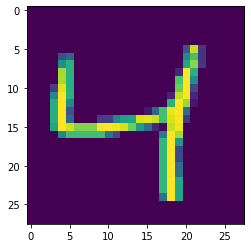

In [ ]:
plt.imshow(x_train[2])

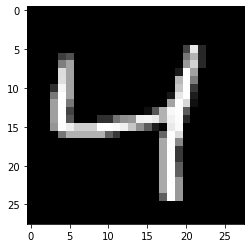

In [ ]:
plt.imshow(x_train[2], cmap='gist_gray')

### Agora, precisamos normalizar nossos pixels dividindo o valor por 255, a fim de ter um intervalo normalizado para nossa rede

Normalizando os valores das imagens de [0, 255] para [0, 1].

In [ ]:
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
single_image_02 = x_train[2]

In [ ]:
single_image_02.min()

0.0

In [ ]:
single_image_02.max()

1.0

## 3. Teoria: uma rede neural de 1 camada

![image_1](https://github.com/YoussefBenDhieb/tensorflow-without-a-phd/blob/master/colabs/assets/1.png?raw=true)

Os dígitos manuscritos no conjunto de dados **MNIST** são imagens em escala de cinza de **28 x 28** pixels.<br />A abordagem mais simples para classificá-los é usar **28 x 28 = 784** pixels como entradas para uma rede neural de **1 camada**.

![](https://github.com/YoussefBenDhieb/tensorflow-without-a-phd/blob/master/colabs/assets/2.png?raw=true)

Cada "neurônio" em uma rede neural faz uma soma ponderada de todas as suas entradas, adiciona uma constante chamada "viés", e em seguida, alimenta o resultado por meio de alguma função de ativação não linear.

Aqui, projetamos uma rede neural de 1 camada com 10 neurônios de saída, pois queremos classificar os dígitos em 10 classes (0 a 9).

Para um problema de classificação, uma função de ativação que funciona bem é a softmax. A aplicação da softmax em um vetor é feita tomando o exponencial de cada elemento e, em seguida, normalizando o vetor (usando qualquer norma, por exemplo, o comprimento euclidiano comum do vetor).

![alt text](https://github.com/YoussefBenDhieb/tensorflow-without-a-phd/blob/master/colabs/assets/3.png?raw=true)

***Por que a "softmax" é chamada de softmax? <br />O exponencial é uma função que aumenta abruptamente. <br />Isso aumentará as diferenças entre os elementos do vetor. <br />Também produz grandes valores rapidamente. <br />Então, conforme você normaliza o vetor, o maior elemento, que domina a norma será normalizado para um valor próximo a 1, enquanto todos os outros elementos serão divididos por um grande valor e normalizados para algo próximo a 0. O vetor resultante mostra claramente qual era o seu maior elemento, o "max", mas retém a ordem relativa original de seus valores, daí o "soft".***

Vamos agora resumir o comportamento dessa única camada de neurônios em uma fórmula simples usando uma multiplicação de matriz.<br /> Vamos fazer isso diretamente para um "minilote" de 100 imagens como entrada, produzindo 100 previsões (vetores de 10 elementos) como saída.

![alt text](https://github.com/YoussefBenDhieb/tensorflow-without-a-phd/blob/master/colabs/assets/4.png?raw=true)

Usando a primeira coluna de pesos na matriz de pesos W, calculamos a soma ponderada de todos os pixels da primeira imagem.<br /> Essa soma corresponde ao primeiro neurônio.<br /> Usando a segunda coluna de pesos, fazemos o mesmo para o segundo neurônio e assim por diante até o 10º neurônio. <br />Podemos então repetir a operação para as 99 imagens restantes. <br />Se chamarmos X de matriz que contém nossas 100 imagens, todas as somas ponderadas de nossos 10 neurônios, calculadas em 100 imagens, serão simplesmente X.W (multiplicação da matriz).

Cada neurônio deve agora adicionar seu viés (uma constante).<br /> Como temos 10 neurônios, temos 10 constantes de **bias**, ou em português, **viés**. <br />Chamaremos esse vetor de 10 valores de **b**. <br />Deve ser adicionado a cada linha da matriz calculada anteriormente. <br />Usando um pouco da mágica chamada "Broadcasting", escreveremos isso com um simples sinal de mais.

***"Broadcasting é um truque padrão usado em Python e numpy. <br />Ele amplia como as operações normais funcionam em matrizes com dimensões incompatíveis.<br /> "Broadcasting add" significa que se você está adicionando duas matrizes, mas não pode porque suas dimensões não são compatíveis, ele tenta replicar a matriz menor tanto quanto necessário para fazer funcionar."***

Finalmente aplicamos a função de ativação ***softmax*** e obtemos a fórmula que descreve uma rede neural de 1 camada, aplicada a 100 imagens:

![alt text](https://github.com/YoussefBenDhieb/tensorflow-without-a-phd/blob/master/colabs/assets/5.png?raw=true)

***O que é um "tensor"?
Um "tensor" é como uma matriz, mas com um número arbitrário de dimensões.<br /> Um tensor unidimensional é um vetor. Um tensor de 2 dimensões é uma matriz. E então você pode ter tensores com 3, 4, 5 ou mais dimensões.***

## 4. Gradiente descendente
Agora que nossa rede neural produz previsões a partir de imagens de entrada, precisamos medir o quão boas elas são, ou seja, a distância entre o que a rede nos diz e o que sabemos ser a verdade. Lembre-se de que temos rótulos verdadeiros para todas as imagens neste conjunto de dados.

Qualquer distância funcionaria, a distância euclidiana comum é boa, mas para problemas de classificação uma distância, chamada de "entropia cruzada", é mais eficiente.

![texto alternativo](https://github.com/YoussefBenDhieb/tensorflow-without-a-phd/blob/master/colabs/assets/6.png?raw=true)

***A codificação "one-hot" significa que você representa o rótulo "6" usando um vetor de 10 valores, todos zeros, mas o 6º valor é 1. É útil aqui porque o formato é muito semelhante ao nosso sistema da rede neural que emite previsões, também em um vetor de 10 valores.***

"Treinar" a rede neural, na verdade, significa usar imagens e rótulos de treinamento para ajustar pesos e vieses de modo a minimizar a função de perda de entropia cruzada. É assim que funciona.

A entropia cruzada é função de pesos, vieses, pixels da imagem de treinamento e seu rótulo conhecido.

Se calcularmos as derivadas parciais da entropia cruzada relativamente a todos os pesos e todos os vieses, obtemos um "gradiente", calculado para uma dada imagem, rótulo e valor presente dos pesos e vieses. Lembre-se de que temos 7.850 pesos e vieses, portanto, calcular o gradiente parece muito trabalhoso. Felizmente, o TensorFlow fará isso por nós.

A propriedade matemática de um gradiente é apontar para "cima". Visto que queremos ir onde a entropia cruzada é baixa, vamos na direção oposta. Atualizamos pesos e tendências (**bias**) por uma fração do gradiente e fazemos a mesma coisa novamente usando o próximo lote de imagens de treinamento. Esperançosamente, isso nos levará ao fundo do poço, onde a entropia cruzada é mínima.

![alt text](https://github.com/YoussefBenDhieb/tensorflow-without-a-phd/blob/master/colabs/assets/7.png?raw=true)

Nesta figura, a entropia cruzada é representada como uma função de 2 pesos. Na realidade, existem muitos mais. O algoritmo de descida gradiente segue o caminho da descida mais íngreme até um mínimo local. As imagens de treinamento também são alteradas a cada iteração para que possamos convergir para um mínimo local que funcione para todas as imagens.

***"Taxa de aprendizagem": você não pode atualizar seus pesos e vieses por todo o comprimento do gradiente em cada iteração. Seria como tentar chegar ao fundo de um vale usando botas de sete léguas. Você estaria pulando de um lado do vale para o outro. Para chegar ao fundo, você precisa fazer etapas menores, ou seja, usar apenas uma fração do gradiente, normalmente na região 1/1000. Chamamos essa fração de "taxa de aprendizado".***

Para resumir, esta é a aparência do loop de treinamento:
`` `
Dígitos e rótulos de treinamento => função de perda => gradiente (derivadas parciais) => descida mais íngreme => atualizar pesos e tendências => repetir com o próximo minilote de imagens de treinamento e rótulos
`` `
<br />
***Por que trabalhar com "minilotes" de 100 imagens e rótulos?***

***Você pode definitivamente calcular seu gradiente em apenas uma imagem de exemplo e atualizar os pesos e vieses imediatamente (é chamado de "descida gradiente estocástica" na literatura científica). Fazer isso em 100 exemplos fornece um gradiente que representa melhor as restrições impostas por diferentes imagens de exemplo e, portanto, provavelmente convergirá para a solução mais rapidamente. O tamanho do minilote é um parâmetro ajustável. Há outro motivo, mais técnico: trabalhar com lotes também significa trabalhar com matrizes maiores e geralmente são mais fáceis de otimizar em GPUs.***

## 5. Laboratório: vamos pular para o código

### Defina o modelo
Nesta seção, construiremos um classificador. Um **classificador** é uma função que pega as características de um objeto (ou "recursos") como entradas e produz uma previsão da classe (ou grupo) a que o objeto pertence. Ele pode fazer uma única previsão para cada entrada ou pode produzir alguma pontuação (por exemplo, uma probabilidade) para cada uma das classes possíveis. Especificamente, construiremos um classificador que recebe (um lote de) 28 x 28 imagens MNIST, como vimos acima, e gera previsões sobre a qual classe a imagem pertence.

Para cada (lote de) imagens de entrada, usaremos uma **rede neural feed-forward** para calcular pontuações não normalizadas (também conhecidas como **logits**) para cada uma das 10 classes possíveis às quais a imagem pode pertencer. Podemos então **classificar** a imagem como pertencente à classe que recebe a pontuação mais alta, ou podemos quantificar a "confiança" do modelo sobre as classificações, convertendo as pontuações em uma distribuição de probabilidade.

Uma rede neural feed-forward que consiste em $N$ camadas, aplicadas a um vetor de entrada $\mathbf{x}$ pode ser definido como:

\begin{equation}
\mathbf{f_0} = \mathbf{x} \\
\mathbf{f_i} = \sigma_i(\mathbf{W_if_{i-1}} + \mathbf{b_i}) \ \ \ i \in [1, N]
\end{equation}

Cada camada tem um número particular, $m_i$, de neurônios. Os parâmetros de uma camada consistem em uma matriz $\mathbf{W_i} \in \mathbb{R}^{m_i \times m_{i-1}}$ e vetor de bias $\mathbf{b_i} \in \mathbb{R}^{m_i}$. Cada camada também tem uma função de ativação não linear $\sigma_i$.

**PERGUNTA**: Por que você acha que as funções de ativação precisam ser **não lineares**? O que aconteceria se elas fossem **lineares**? **DICA**: Se você estiver travado, considere o caso mais simples de uma ativação de identidade (que essencialmente não faz nada) e ignore os preconceitos.

### Funções de ativação

As funções de ativação são um ingrediente central nas redes neurais profundas. Na verdade, são elas que nos permitem fazer uso de várias camadas em uma rede neural. Existem várias funções de ativação diferentes, cada uma das quais mais ou menos útil em diferentes circunstâncias. As quatro funções de ativação que você provavelmente encontrará são, sem dúvida,[ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU), [Tanh](https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh), [Sigmoid](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid), e [Softmax](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Softmax)..

ReLU, nos últimos anos, tornou-se a escolha padrão para uso em MLPs e Redes Neurais Convolucionais (CNNs). ReLU tem duas vantagens sobre Tanh e Sigmoid: é computacionalmente muito mais eficiente e nos permite usar redes mais profundas porque não sofre de [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). Como resultado de seu sucesso, uma série de variantes ReLU, como [LeakyRelu](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) e [PReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/PReLU), foram desenvolvidos.

As ativações Sigmoid e Softmax são frequentemente encontradas após a última camada em redes de classificação binária e multiclasse, respectivamente, pois transformam as saídas da rede de forma que possamos interpretá-las como probabilidades de classe.

Tanh e Sigmoid são encontradas em redes neurais recorrentes LSTM e GRU, sobre as quais aprenderemos mais nos próximos episódios. Elas também são úteis em MLPs e CNNs, onde queremos que a saída seja limitada entre -1 e 1 (Tanh) ou 0 e 1 (Sigmóide).

Leia mais sobre as funções de ativação [aqui](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6).

### Crie uma rede neural de 1 camada
Configuramos a parte da rede neural feed-forward de nosso classificador usando a [Keras Layers API](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Esta API consiste em vários blocos de construção reutilizáveis ​​que nos permitem definir muitas arquiteturas de rede neural diferentes (semelhante a como definimos um pipeline de dados anteriormente!).

Aqui usamos o componente [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) que nos permite agrupar uma sequência de camadas. Um ponto importante a observar aqui é que estamos **configurando** nossa arquitetura de rede neural como um pipeline. Podemos pensar na variável `` `model`` resultante como uma **função** que pega um lote de imagens como entradas e produz um lote de logits.


In [ ]:
# Define o modelo
model = tf.keras.models.Sequential([
# achata as imagens em uma única linha de pixels, um vetor
  tf.keras.layers.Flatten(input_shape=(28, 28), name='flatten_input'),
# aplica softmax como uma função de ativação
  tf.keras.layers.Dense(10, activation=tf.nn.softmax, name='logits')
])

O resumo a seguir mostra quantos parâmetros cada camada é composta (o número de entradas na matriz de pesos e vetores de bias). Observe que um valor de ```None``` em uma dimensão específica, significa que a forma se adaptará dinamicamente com base na forma das entradas. Em particular, a forma de saída do ```flatten_input``` será $[N, 784]$ quando o lote de entradas passado para o modelo tem a forma $[N, 28, 28]$

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_input (Flatten)      (None, 784)               0         
_________________________________________________________________
logits (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Defina a perda
Como fizemos na prática anterior, precisamos especificar uma função de perda para nosso classificador. Isso nos diz o quão boas são as previsões do nosso modelo em comparação com os rótulos reais (os alvos), com uma perda menor significando melhores previsões. A função de perda padrão para usar com um **classificador multiclasse** é a **perda de entropia cruzada** também conhecida como "probabilidade de log negativo". Suponha que temos um problema de classificação com classes $C$. Um classificador é treinado para prever uma distribuição de probabilidade $p(y|X_i)$ para cada entrada $X_i$ de um lote de $N$ exemplos. O vetor $p(y|X_i)$ é $C$ dimensional, soma um, e usamos $p(y|X_i)_c$ para denotar o $c$ th componente de $p(y|X_i)$. A verdadeira classe por exemplo $i$ no lote é $y_i$ e definimos a função indicadora $\mathbb{1}[y_i = c]$ como 1 sempre que $y_i=c$ e $0$ caso contrário. Este classificador tem uma perda de entropia cruzada de

$- \frac{1}{N}\sum_{i=1}^N \sum_{c=1}^C log( p(y|X_i)_c) \mathbb{1}[y_i=c]$

**NOTA**: O indicador é um para o verdadeiro rótulo da classe e zero para todas as outras. Portanto, nessa soma, o indicador apenas "levanta" os valores $log(p(y|X_i))$ para todas as classes verdadeiras. Portanto, a expressão acima é minimizada (observe o negativo na frente) quando o modelo coloca toda a sua massa de probabilidade nos rótulos verdadeiros para todos os exemplos. Lembre-se de que log(1) = 0, portanto, quanto mais próximas de um todas as probabilidades de $y_i = c$, menor será a perda e melhor será o desempenho do modelo.

**PERGUNTA**:
* Por que você acha que esta é uma função de perda *boa*?
* Você consegue pensar em algum problema potencial com essa função de perda?

Felizmente, não precisamos escrever essa função, pois o Tensorflow fornece uma versão chamada

```tf.nn.sparse_softmax_cross_entropy_with_logits```.

**NOTA**: Esta função realmente calcula a perda de entropia cruzada diretamente dos logits não normalizados, ao invés da distribuição de probabilidade para estabilidade numérica.

A propósito, para dados de treinamento em que os próprios rótulos são distribuições em vez de valores exatos, essa definição de entropia cruzada ainda funciona, onde a função de indicador é substituída pela probabilidade correspondente de cada classe para aquele exemplo. Isso pode ser importante quando não temos certeza se os dados de treinamento foram rotulados corretamente ou quando os dados foram rotulados por um humano que deu sua resposta junto com um certo grau de confiança de que a resposta estava correta.

### Treine o modelo
Agora que temos nossos dados, pipeline de processamento de dados, nossa arquitetura de rede neural e a perda correspondente que queremos minimizar, precisamos **treinar** o modelo usando descida gradiente estocástica em lote. Fazemos isso em várias **épocas**, que é uma única iteração em todo o conjunto de dados de treinamento. Resumidamente, em cada época, fazemos um loop em todos os lotes de imagens e rótulos e, para cada lote, executamos as seguintes etapas:
* Obtenha as **previsões** do modelo no lote atual de imagens
* Calcule os valores de **perda média** em todo o lote, informando-nos quão boas são essas previsões / quão próximas estão dos alvos verdadeiros.
* Calcule o **gradiente da perda média** (ou o gradiente médio das perdas no lote) com relação a cada um dos parâmetros do modelo: Isso nos diz a direção para mover no "espaço de parâmetros" para diminuir o valor da perda
* **Ajuste os parâmetros** dando um pequeno passo na direção de cada componente do gradiente (onde a taxa de aprendizado controla o tamanho do passo)

Durante o treinamento, também rastreamos algumas métricas, como a perda e a precisão, para ver como o classificador está se saindo. Observe que a célula abaixo pode levar alguns minutos para ser executada!

In [ ]:
def train_model():
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])


  tensorboard_callback = tf.keras.callbacks.TensorBoard(histogram_freq=1)

  model.fit(x=x_train,
            y=y_train,
            batch_size=100,
            epochs=300,
            validation_data=(x_test, y_test),
            callbacks=[tensorboard_callback])

train_model()

Epoch 1/300
600/600 [==============================] - 2s 2ms/step - loss: 1.4880 - accuracy: 0.6318 - val_loss: 1.0013 - val_accuracy: 0.8062
Epoch 2/300
600/600 [==============================] - 1s 1ms/step - loss: 0.8656 - accuracy: 0.8187 - val_loss: 0.7299 - val_accuracy: 0.8444
Epoch 3/300
600/600 [==============================] - 1s 1ms/step - loss: 0.6925 - accuracy: 0.8443 - val_loss: 0.6177 - val_accuracy: 0.8609
Epoch 4/300
600/600 [==============================] - 1s 1ms/step - loss: 0.6086 - accuracy: 0.8573 - val_loss: 0.5553 - val_accuracy: 0.8705
Epoch 5/300
600/600 [==============================] - 1s 1ms/step - loss: 0.5575 - accuracy: 0.8649 - val_loss: 0.5146 - val_accuracy: 0.8762
Epoch 6/300
600/600 [==============================] - 1s 1ms/step - loss: 0.5227 - accuracy: 0.8708 - val_loss: 0.4855 - val_accuracy: 0.8812
Epoch 7/300
600/600 [==============================] - 1s 1ms/step - loss: 0.4971 - accuracy: 0.8747 - val_loss: 0.4638 - val_accuracy: 0.8836

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
#@title Visualize no TensorBoard (EXECUTE-ME!) { display-mode: "form" }

get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://ec48-104-199-196-116.ngrok.io
